In [33]:
import numpy as np
from numpy import array
from numpy import hstack
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,12)
import pandas as pd
import math
from statsmodels.tsa.seasonal import STL
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

np.random.seed(5)

In [45]:
time_steps = 3
n_features = 1
n_epochs = 60
MODEL = "precio_petroleo_cantidad"
DATASET = "g1"
SEGMENTO = "post"


In [46]:
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		end_ix = i + n_steps
		if end_ix > len(sequences):
			break
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [47]:
data = pd.read_csv(
    "../Data/" + MODEL + "/papas_" + DATASET + "_" + SEGMENTO + ".csv", engine="python"
)
petroleo = pd.read_csv(
    "../Data/" + MODEL + "/petroleo_" + SEGMENTO + ".csv", engine="python"
)
data_petroleo = petroleo["precio"]
procedencia = pd.read_csv(
    "../Data/"
    + MODEL
    + "/papas_procedencia_"
    + DATASET
    + "_total_"
    + SEGMENTO
    + ".csv",
    engine="python",
)
data_procedencia = procedencia["cantidad (TM)"]

data_petroleo = data_petroleo.values
data_petroleo = data_petroleo.astype("float32")
data_petroleo = data_petroleo.reshape((len(data_petroleo), 1))

data_procedencia = data_procedencia.values
data_procedencia = data_procedencia.astype("float32")
data_procedencia = data_procedencia.reshape((len(data_procedencia), 1))


In [48]:
model = Sequential()
model.add(LSTM(30, input_shape=(time_steps, 5)))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam")

testSets = {}
crops = data["producto"].unique().tolist()
for crop in crops:
    cropData = data[data.producto == crop]["precio_mean"]

    stl = STL(cropData, seasonal=13, period=12)
    res = stl.fit()

    data_trend = res.trend
    data_season = res.seasonal
    data_resid = res.resid

    data_trend = data_trend.values
    data_trend = data_trend.astype("float32")
    data_trend = data_trend.reshape((len(data_trend), 1))

    data_season = data_season.values
    data_season = data_season.astype("float32")
    data_season = data_season.reshape((len(data_season), 1))

    data_resid = data_resid.values
    data_resid = data_resid.astype("float32")
    data_resid = data_resid.reshape((len(data_resid), 1))

    cropPrice = cropData.values
    cropPrice = cropPrice.astype("float32")
    cropPrice = cropPrice.reshape((len(cropPrice), 1))

    dataset = hstack(
        (
            data_trend,
            data_season,
            data_resid,
            data_petroleo,
            data_procedencia,
            cropPrice,
        )
    )

    train = dataset[0 : int(dataset.shape[0] * 0.8), :]
    test = dataset[int(dataset.shape[0] * 0.8) : len(dataset), :]

    trainX, trainY = split_sequences(train, time_steps)
    testX, testY = split_sequences(test, time_steps)

    model.fit(trainX, trainY, epochs=n_epochs, verbose=2)

    testSets[crop] = {
        "trainX": trainX,
        "trainY": trainY,
        "testX": testX,
        "testY": testY,
        "output": cropPrice,
    }


Epoch 1/60
25/25 - 1s - loss: 5.1351 - 935ms/epoch - 37ms/step
Epoch 2/60
25/25 - 0s - loss: 1.7454 - 29ms/epoch - 1ms/step
Epoch 3/60
25/25 - 0s - loss: 0.3922 - 28ms/epoch - 1ms/step
Epoch 4/60
25/25 - 0s - loss: 0.2060 - 28ms/epoch - 1ms/step
Epoch 5/60
25/25 - 0s - loss: 0.1631 - 30ms/epoch - 1ms/step
Epoch 6/60
25/25 - 0s - loss: 0.1528 - 30ms/epoch - 1ms/step
Epoch 7/60
25/25 - 0s - loss: 0.1467 - 29ms/epoch - 1ms/step
Epoch 8/60
25/25 - 0s - loss: 0.1464 - 29ms/epoch - 1ms/step
Epoch 9/60
25/25 - 0s - loss: 0.1359 - 30ms/epoch - 1ms/step
Epoch 10/60
25/25 - 0s - loss: 0.1277 - 33ms/epoch - 1ms/step
Epoch 11/60
25/25 - 0s - loss: 0.1242 - 30ms/epoch - 1ms/step
Epoch 12/60
25/25 - 0s - loss: 0.1345 - 30ms/epoch - 1ms/step
Epoch 13/60
25/25 - 0s - loss: 0.1159 - 28ms/epoch - 1ms/step
Epoch 14/60
25/25 - 0s - loss: 0.1015 - 27ms/epoch - 1ms/step
Epoch 15/60
25/25 - 0s - loss: 0.0871 - 26ms/epoch - 1ms/step
Epoch 16/60
25/25 - 0s - loss: 0.0730 - 27ms/epoch - 1ms/step
Epoch 17/60
25/

7/7 [==============================] - 0s 666us/step
PAPA AMARILLA
Train Score: 2.8959% MAPE
Test Score: 10.6303% MAPE


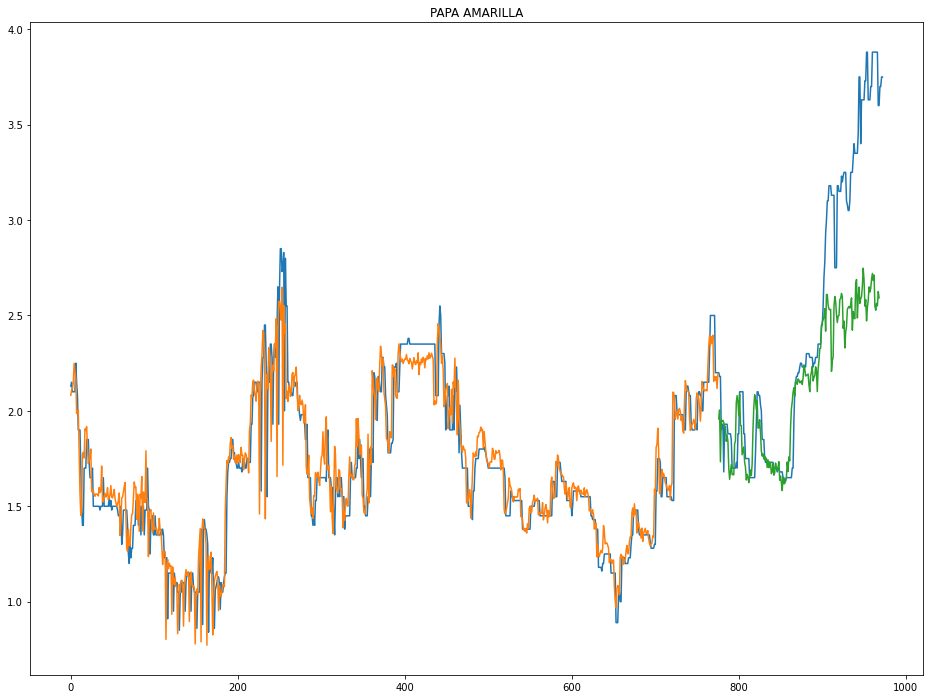

7/7 [==============================] - 0s 667us/step
PAPA HUAYRO (ROJO-MORO-NEGRO)RUNT/MARH/U
Train Score: 4.2899% MAPE
Test Score: 1.7100% MAPE


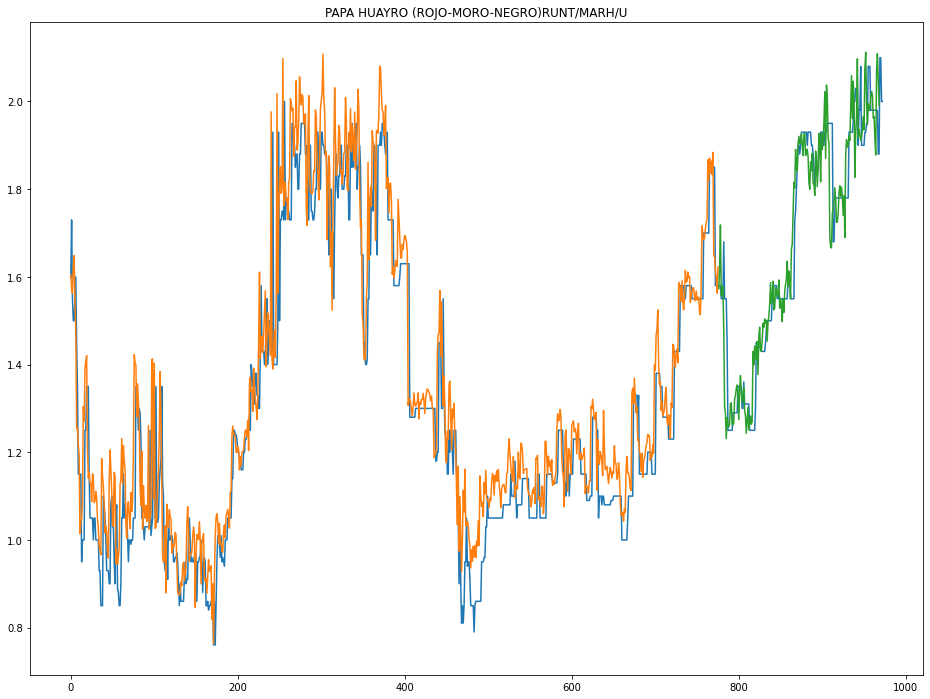

7/7 [==============================] - 0s 750us/step
PAPA HUAMANTANGA
Train Score: 3.6261% MAPE
Test Score: 3.0537% MAPE


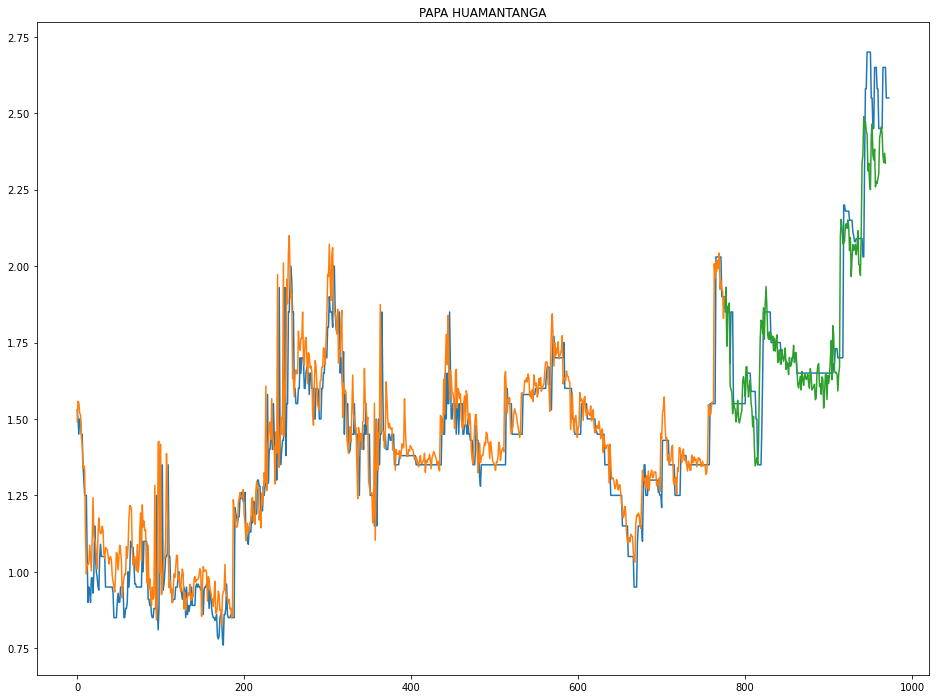

7/7 [==============================] - 0s 667us/step
PAPA PERUANITA (INJERTO)
Train Score: 3.2075% MAPE
Test Score: 3.4534% MAPE


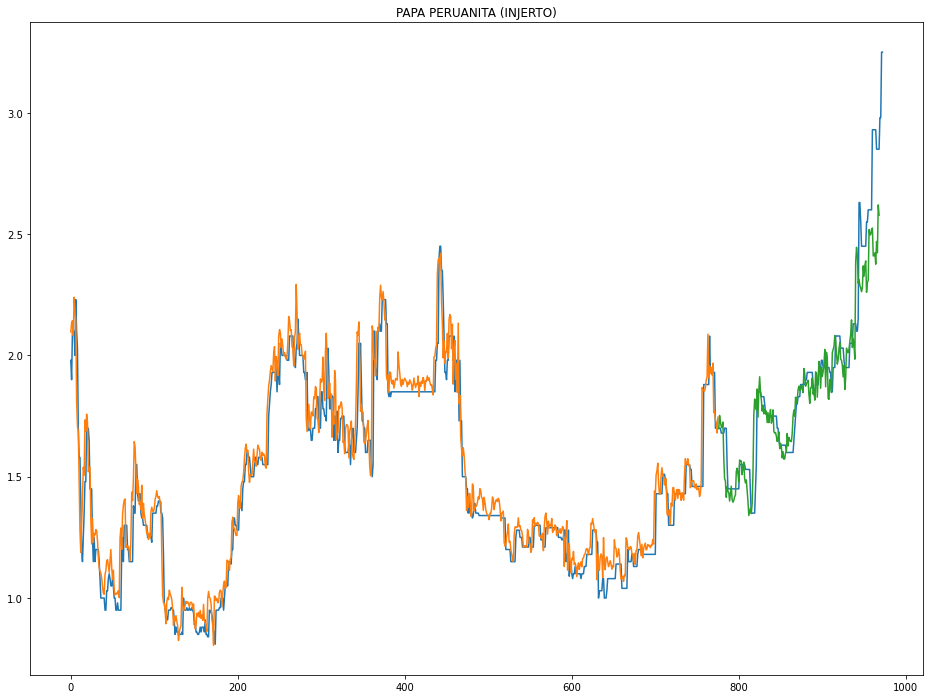

In [49]:
for crop in testSets:
    trainPredict = model.predict(testSets[crop]['trainX'])
    testPredict = model.predict(testSets[crop]['testX'])
    
    print(crop)
    trainScore = mean_absolute_percentage_error(testSets[crop]['trainY'], trainPredict[:,0])
    print('Train Score: %.4f%% MAPE' % (trainScore * 100))
    testScore = mean_absolute_percentage_error(testSets[crop]['testY'], testPredict[:,0])
    print('Test Score: %.4f%% MAPE' % (testScore * 100))

    testPredictPlot = np.empty((len(trainPredict),1,))
    testPredictPlot[:] = np.nan
    testPredictPlot = np.concatenate((testPredictPlot,testPredict))

    plt.title(crop)
    plt.plot(testSets[crop]['output'])
    plt.plot(trainPredict)
    plt.plot(testPredictPlot)
    plt.show()